### Investigate misclassified data
--- 
After building the baselines, we investigate the misclassified data to look for patterns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

from sqlalchemy import create_engine
from tqdm import tqdm
from rdsutils.aws import download_s3, python_object_to_s3
from rdsutils.analysis import get_misclassified_high_risk_rows, build_summary
import rdsutils.plot as rdsplot

%load_ext autoreload
%autoreload 2

In [2]:
modeling_df = pd.read_parquet('../../artifacts/20200920/modeling_df_w_baseline_preds.parquet')

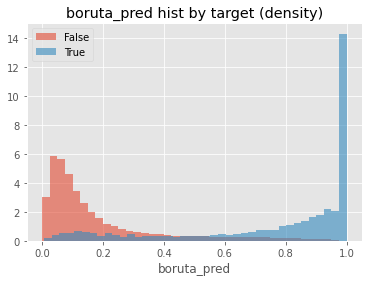

In [3]:
rdsplot.hist_by_target('boruta_pred', 'ach_target', modeling_df)

The pattern or ACH is much cleaner than MCD. 

In [10]:
meta_cols = ['borrower_id', 'business_account_number', 'ach_target', 
             'boruta_pred', 'real_ending_balance', 'transaction_amount',
             'account_closed_by_risk_in_next_90d', 'nr_returns_in_next_5d']
df = modeling_df[meta_cols]
df = df.loc[df['ach_target']]
df = get_misclassified_high_risk_rows(df, 'transaction_amount', 'boruta_pred')
display(df)

,borrower_id,business_account_number,ach_target,boruta_pred,real_ending_balance,transaction_amount,account_closed_by_risk_in_next_90d,nr_returns_in_next_5d
7753876,38704,410001743824,True,0.109560,61011.73,50000.0,False,1.0
8747931,7877594,410001959615,True,0.182500,75709.75,50000.0,False,1.0
7972827,7734122,410001789737,True,0.216921,50135.85,50000.0,False,2.0
8441021,4674252,410001884084,True,0.250612,156225.75,50000.0,False,1.0
73917,3116972,410000074416,True,0.441121,50919.34,50000.0,False,1.0
...,...,...,...,...,...,...,...,...
14981278,10141632,410005776864,True,0.996610,1.00,1.0,False,1.0
14637470,9759002,410004990823,True,0.997221,1.00,1.0,True,1.0
14855810,9253974,410005427877,True,0.997592,1.00,1.0,False,1.0
14609292,9746176,410004962626,True,0.998221,1.00,1.0,True,2.0


Get the group of data to focus on:
* prediction less than a threshold (0.2), and order by the dollar value involved

In [11]:
focus_on_df = df[df.boruta_pred < 0.2].sort_values('boruta_pred', ascending=True)
df_by_account = focus_on_df.groupby(['business_account_number'])['boruta_pred', 'real_ending_balance'].agg(['mean', 'count'])
df_by_account = df_by_account.sort_values(by=[('real_ending_balance', 'mean')], ascending=False)
df_by_account.head()

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  from ipykernel import kernelapp as app


boruta_pred       real_ending_balance      
                               mean count                mean count
business_account_number                                            
410000523964               0.089252     1           243864.41     1
410001617710               0.070874     1           202216.40     1
410002097539               0.140379     1           163019.92     1
410000313171               0.122210     1           115234.18     1
410000781931               0.060199     1            92059.48     1

Get the business ids

In [12]:
baids = df_by_account.index
baids, len(df_by_account)

(Int64Index([410000523964, 410001617710, 410002097539, 410000313171,
             410000781931, 410001959615, 410002556325, 410001810216,
             410002303287, 410001743824,
             ...
             410006061668, 410002606935, 410004751244, 410006142864,
             410005737958, 410005324791, 410005564765, 410000863669,
             410005419140, 410000741953],
            dtype='int64', name='business_account_number', length=316),
 316)